# Recreación de resultados previos
En este notebook, se quiere explorar el uso de las fuentes de datos necesarias para el trabajo fin de master *Detecting Intermediate Mass Black Holes in globular clusters using Gaia Home*. Dichas fuentes de datos son:
- Gaia DR3
- XMMNewton (3XMM-DR8 catalogue)
- Chandra (Chandra Source Catalogue-CSC-R2)

Otro objetivo de este notebook es obtener un punto de partida recreando los resultados expuestos en [Tracing black holes in globular clusters with Gaia](https://santiago-ucm.atlassian.net/wiki/spaces/IMBH/overview?homepageId=98423) usando los resultados de DR3 en vex de DR2.


Usaremos astropy  y astroquery para la explotación de las bases de datos. De manera adicional, para la obtención de las coordenadas de los cúmulos globulares usaremos el catálogo *Globular Cluster Systems of Galaxies Catalog* (GCSCAT) integrado en Heasarc. 

In [1]:
%load_ext autoreload
%autoreload 2


#@markdown ### Librerías y funciones auxiliares
import sys
import os

# Añadir el directorio raíz del proyecto al sys.path
project_path = os.path.abspath(os.path.join(os.getcwd(), ".."))  # Subir un nivel
if project_path not in sys.path:
    sys.path.append(project_path)
    
import astropy.units as u
from astropy.table import Table
from astropy.coordinates import SkyCoord
from astroquery.gaia import Gaia
from astroquery.simbad import Simbad
from astroquery.heasarc import Heasarc
from astroquery.esa.xmm_newton import XMMNewton

from src.gaia_dr3.etls.download_data import get_object, get_object_from_simbad, get_cluster, get_skycoords, get_object_from_heasarc
from src.gaia_dr3.etls.stadistics import get_uwe_from_gaia, get_u0_g_c, get_ruwe_from_gaia
from src.gaia_dr3.etls.utils import convert_mas_yr_in_km_s, get_l_b_velocities
from src.ruwe_calculation.ruwetools import U0Interpolator

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.colors as mcolor


#Establecemos que las consultas de GAIA no tenga límites de filas
Gaia.ROW_LIMIT = -1

## Tracing black holes in globular clusters with Gaia 

Empezaremos con los resultados presentados en [Tracing black holes in globular clusters with Gaia](https://santiago-ucm.atlassian.net/wiki/spaces/IMBH/overview?homepageId=98423), donde se detalla el objetivo final del proyecto: La obtención de un algoritmos capaz de detectar globulos candidatos a albergar un IMBH.

Para ello, se presenta como ejemplo de cúmulo 47 Tucanae (NGC 104), en el cual existen grandes indicios de la presencia de un agujero negro de masa intermedia (sobre $2300 M_\odot$ (Kızıltan et al., 2017)). Vamos a generar dos primeros catálogos
- GCngc104_r.vot: Todas las estrllas en GAIA DR3 dentro del radio del cluster Rc.
- GCngc104_6r.vot: Todas las estrllas en GAIA DR3 dentro de seis veces el radio del cluster (6Rc) y que cumplan:
    - pmra > 50 Km/s y pmdec > 50 Km/s.
    - valores positvos para el paralaje
    - Errores en el paralaje por debajo del 30%.

In [4]:
NAME_CLUSTER = "ngc104"
Gaia.MAIN_GAIA_TABLE = "gaiadr3.gaia_source" 
Gaia.ROW_LIMIT = -1

result_cluster = get_object_from_heasarc(NAME_CLUSTER)
result_cluster = get_object_from_heasarc(NAME_CLUSTER)
coords = get_skycoords(result_cluster, u.deg, u.deg)
# Coordenadas aproximadas de NGC 104 (47 Tucanae)
ra = coords.ra.value  # Ascensión recta (RA) en grados
dec = coords.dec.value  # Declinación (Dec) en grados
radius = np.power(10, result_cluster["CENTRAL_CONCENTRATION"].value[0]) * result_cluster["CORE_RADIUS"].value[0] / 60

result_cluster

NAME,RA,DEC,CORE_RADIUS,HALF_LIGHT_RADIUS,CENTRAL_CONCENTRATION,SEARCH_OFFSET_
,deg,deg,arcmin,arcmin,,
bytes9,float64,float64,float64,float64,float64,bytes15
NGC 104,6.02363,-72.08128,0.36,3.17,2.07,0.026 (ngc104)\n


### Lectura de resultados desde GAIA DR2
Leemos los datos desde la base de datos de Gaia. Saltar este paso si existen datos ya descargados.

In [146]:

job = Gaia.launch_job_async(f"""
SELECT * FROM gaiadr3.gaia_source
WHERE 1=CONTAINS(
    POINT('ICRS', ra, dec),
    CIRCLE('ICRS', {ra}, {dec}, {radius * 1})
)
""",dump_to_file=True, output_format='votable', output_file="DR3_GCngc104_r.vot")
print(job)
results = job.get_results()
df_r = results.to_pandas()
df_r

Jobid: 1739570377250O
Phase: COMPLETED
Owner: None
Output file: DR3_GCngc104_r.vot
Results: None


,solution_id,DESIGNATION,SOURCE_ID,random_index,ref_epoch,ra,ra_error,dec,dec_error,parallax,...,azero_gspphot,azero_gspphot_lower,azero_gspphot_upper,ag_gspphot,ag_gspphot_lower,ag_gspphot_upper,ebpminrp_gspphot,ebpminrp_gspphot_lower,ebpminrp_gspphot_upper,libname_gspphot
0,1636148068921376768,Gaia DR3 4689621262329503744,4689621262329503744,117828161,2016.0,5.934553,0.537742,-72.252166,0.742929,-2.907118,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,
1,1636148068921376768,Gaia DR3 4689859169153623936,4689859169153623936,661937160,2016.0,6.723713,0.234891,-71.538202,0.198667,-0.215250,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,
2,1636148068921376768,Gaia DR3 4688774874596135552,4688774874596135552,733088451,2016.0,5.706035,0.182295,-72.777653,0.166385,-0.035948,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,
3,1636148068921376768,Gaia DR3 4688774874596136704,4688774874596136704,869981144,2016.0,5.745000,0.362256,-72.773082,0.320210,0.221080,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,
4,1636148068921376768,Gaia DR3 4688774908955873664,4688774908955873664,1668059797,2016.0,5.653303,0.341389,-72.776422,0.302677,0.304682,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
180971,1636148068921376768,Gaia DR3 4689629985430016512,4689629985430016512,196543525,2016.0,6.828311,2.468688,-72.078526,1.134871,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,
180972,1636148068921376768,Gaia DR3 4689629985432578560,4689629985432578560,1022114443,2016.0,6.839266,0.203694,-72.074864,0.158569,0.000232,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,
180973,1636148068921376768,Gaia DR3 4689629985432588288,4689629985432588288,93684263,2016.0,6.832372,1.853926,-72.069998,1.529677,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,
180974,1636148068921376768,Gaia DR3 4689629989704549888,4689629989704549888,1229703459,2016.0,6.847079,1.082456,-72.065732,0.820332,1.939339,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,


In [5]:
job = Gaia.launch_job_async(f"""
SELECT * FROM gaiadr3.gaia_source
WHERE 1=CONTAINS(
    POINT('ICRS', ra, dec),
    CIRCLE('ICRS', {ra}, {dec}, {radius * 6})
) AND parallax_error < 0.30 AND parallax > 0 AND parallax < 1
""",dump_to_file=True, output_format='votable', output_file="DR3_GCngc104_6r.vot")
print(job)
results = job.get_results()
df_r6 = results.to_pandas()
df_r6

Jobid: 1739571064837O
Phase: COMPLETED
Owner: None
Output file: DR3_GCngc104_6r.vot
Results: None


,solution_id,DESIGNATION,SOURCE_ID,random_index,ref_epoch,ra,ra_error,dec,dec_error,parallax,...,azero_gspphot,azero_gspphot_lower,azero_gspphot_upper,ag_gspphot,ag_gspphot_lower,ag_gspphot_upper,ebpminrp_gspphot,ebpminrp_gspphot_lower,ebpminrp_gspphot_upper,libname_gspphot
0,1636148068921376768,Gaia DR3 4688344862469326848,4688344862469326848,1633924207,2016.0,1.353637,0.216034,-74.509028,0.213074,0.248422,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,
1,1636148068921376768,Gaia DR3 4688864038125737472,4688864038125737472,1435015555,2016.0,9.870946,0.192017,-73.253109,0.175196,0.020099,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,
2,1636148068921376768,Gaia DR3 4684694174630090368,4684694174630090368,134164906,2016.0,11.573803,0.205038,-75.274122,0.166678,0.114362,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,
3,1636148068921376768,Gaia DR3 4684728568727518848,4684728568727518848,1242636498,2016.0,12.666456,0.230744,-74.644985,0.203195,0.334984,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,
4,1636148068921376768,Gaia DR3 4684728568727520512,4684728568727520512,1680088756,2016.0,12.684400,0.175559,-74.644200,0.171592,0.190307,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
864564,1636148068921376768,Gaia DR3 4685968994011611776,4685968994011611776,1048261422,2016.0,14.354821,0.218333,-72.761648,0.208755,0.048700,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,
864565,1636148068921376768,Gaia DR3 4685968994011613056,4685968994011613056,362275687,2016.0,14.335327,0.070642,-72.767622,0.066511,0.105240,...,0.8523,0.8051,0.8986,0.6515,0.6150,0.688,0.3487,0.3292,0.3679,PHOENIX
864566,1636148068921376768,Gaia DR3 4685968994011613184,4685968994011613184,504865727,2016.0,14.366305,0.089830,-72.769379,0.083419,0.064206,...,0.0760,0.0578,0.0949,0.0615,0.0467,0.077,0.0337,0.0255,0.0422,PHOENIX
864567,1636148068921376768,Gaia DR3 4685968994011613568,4685968994011613568,288116170,2016.0,14.322506,0.169886,-72.768310,0.162537,0.606401,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,


#### Lectrua del XMMNewton

In [59]:
coords = get_skycoords(result_cluster, u.deg, u.deg)
# Coordenadas aproximadas de NGC 104 (47 Tucanae)
ra = coords.ra.value  # Ascensión recta (RA) en grados
dec = coords.dec.value  # Declinación (Dec) en grados
radius = 1  # Radio de búsqueda en grados

# # Ejecutar la consulta TAP
query_results = XMMNewton.query_xsa_tap(f"""
SELECT * FROM v_public_observations
WHERE 1=CONTAINS(
    POINT('ICRS', ra, dec),
    CIRCLE('ICRS', {ra}, {dec}, {radius})
)
""")

# # Mostrar los resultados
discard_cols = ['observation_equatorial_spoint', 'observation_fov_scircle', 'observation_galactic_spoint']
df_x = query_results[[col for col in query_results.columns if col not in discard_cols]].to_pandas()
df_x

,bii,dec,duration,end_utc,footprint_fov,heasarc_code,lii,moving_target,observation_id,observation_oid,...,proprietary_end_date,ra,ra_nom,revolution,sas_version,seq_id,start_utc,stc_s,target,with_science
0,-45.625931,-71.3760,45663,2005-03-27T07:08:00.0,"[6.97642739596898, -71.6596685411531, 6.708070...",1710,305.653024,False,0164570701,57314,...,2005-03-26T00:00:00.0,6.892000,0.459467,970,xmmsas_20190401_1820-18.0.0,134403,2005-03-26T18:26:57.0,Polygon J2000 6.990551742804176 -71.6596569698...,GRB 050326,True
1,-44.578082,-72.3925,16014,2011-09-18T05:11:17.0,"[5.86966368065718, -72.6420088303927, 5.839877...",5000,305.862077,False,0679180301,62974,...,2012-04-21T00:00:00.0,5.945833,0.396389,2156,xmmsas_20190401_1820-18.0.0,140242,2011-09-18T00:44:23.0,Polygon J2000 5.869663680657179 -72.6420088303...,PLCK G305.9-44.6,True


In [79]:
df_x.duration

0    45663
1    16014
Name: duration, dtype: int64

#### Lectura de datos desde archivo
Si existen datos descargados se pueden descargar a través de estas líneas

In [80]:
df_r = Table.read("DR3_GCngc104_r.vot", format="votable").to_pandas()
df_r6 = Table.read("DR3_GCngc104_6r.vot", format="votable").to_pandas()

print("GCngc104_r Rows: %i "% df_r.shape[0])
print("GCngc104_r5 Rows: %i "% df_r6.shape[0])

GCngc104_r Rows: 180976 
GCngc104_r5 Rows: 5444 


### Formateo de los resultados
Calculamos métricas auxiliares para cada una de lso catálogos descargados

In [83]:
df_r["pmra_kms"] = convert_mas_yr_in_km_s(df_r["parallax"].values, df_r["pmra"].values)
df_r["pmdec_kms"] = convert_mas_yr_in_km_s(df_r["parallax"].values, df_r["pmdec"].values)
df_r["pm_kms"] = np.sqrt(df_r.pmra_kms ** 2 + df_r.pmdec_kms**2)
df_r["pm"] = np.sqrt(df_r.pmra ** 2 + df_r.pmdec**2)
df_r["pm_l"], df_r["pm_b"] = get_l_b_velocities(df_r.pmra, df_r.pmdec, df_r.l, df_r.b)

df_r6["pmra_kms"] = convert_mas_yr_in_km_s(df_r6["parallax"].values, df_r6["pmra"].values)
df_r6["pmdec_kms"] = convert_mas_yr_in_km_s(df_r6["parallax"].values, df_r6["pmdec"].values)
df_r6["pm_kms"] = np.sqrt(df_r6.pmra_kms ** 2 + df_r6.pmdec_kms**2)
df_r6["pm_l"], df_r6["pm_b"] = get_l_b_velocities(df_r6.pmra, df_r6.pmdec, df_r6.l, df_r6.b)
df_r6["pm"] = np.sqrt(df_r6.pmra ** 2 + df_r6.pmdec**2)

Aplicamos un filtro de calidad a través de la métrica RUWE (ver GAIA-C3-TN-LU-LL-124-01.pdf). Además:
- Eliminamos los paralajes negativos incluyendo el error estimado para el catálogo "GCngc104_r"
- Aplicamos el filtro de movimientos propios mayores a 50 Km/s en "GCngc104_r6"

In [84]:
rwi = U0Interpolator()

df_r["uwe"] = get_uwe_from_gaia(df_r, 5)
df_r["ruwe"] = df_r['uwe']/ rwi.get_u0(df_r['phot_g_mean_mag'], df_r['bp_rp'])
df_r6["uwe"] = get_uwe_from_gaia(df_r6, 5)
df_r6["ruwe"] = df_r6['uwe']/ rwi.get_u0(df_r6['phot_g_mean_mag'], df_r6['bp_rp'])

df_r = df_r[(df_r.ruwe < 1.40)]
df_r6 = df_r6[(df_r6.ruwe < 1.40) & (df_r6.pmra_kms > 50) & (df_r6.pmdec_kms > 50)]

parallax = df_r.parallax
parallax_error = df_r.parallax_error * parallax.abs()
# df_r = df_r[parallax + parallax_error > 0]

print("GCngc104_r Rows: %i "% df_r.shape[0])
print("GCngc104_r5 Rows: %i "% df_r6.shape[0])

GCngc104_r Rows: 154362 
GCngc104_r5 Rows: 5444 


Una vez filtrado los dos catálogos se generan cuatro catálogos más por catálogo genereal con las siguientes características:
- `_c1`: Todas las estrellas.
- `_c2`: Error en el paralaje, movimiento propio en declinaje y ascensión recta por debajo del 10%.
- `_c3`: Error en el paralaje por debajo del 30% y del movimiento propio en declinaje y ascensión recta por debajo del 10%.
- `_c4`: Error en el paralaje por debajo del 10% y del movimiento propio en declinaje y ascensión recta por debajo del 30%.

In [85]:
dfr1_c1 = df_r.copy()
dfr1_c2 = df_r[(df_r.pmra_error < 0.10) & (df_r.pmdec_error < 0.10) & (df_r.parallax_error < 0.10)]
dfr1_c3 = df_r[(df_r.pmra_error < 0.10) & (df_r.pmdec_error < 0.10) & (df_r.parallax_error < 0.30)]
dfr1_c4 = df_r[(df_r.pmra_error < 0.30) & (df_r.pmdec_error < 0.30) & (df_r.parallax_error < 0.10)]

dfr6_c1 = df_r6.copy()
dfr6_c2 = df_r6[(df_r6.pmra_error < 0.10) & (df_r6.pmdec_error < 0.10) & (df_r6.parallax_error < 0.10)]
dfr6_c3 = df_r6[(df_r6.pmra_error < 0.10) & (df_r6.pmdec_error < 0.10) & (df_r6.parallax_error < 0.30)]
dfr6_c4 = df_r6[(df_r6.pmra_error < 0.30) & (df_r6.pmdec_error < 0.30) & (df_r6.parallax_error < 0.10)]


print("GCngc104_r Rows C1: %i "% dfr1_c1.shape[0])
print("GCngc104_r Rows C2: %i "% dfr1_c2.shape[0])
print("GCngc104_r Rows C3: %i "% dfr1_c3.shape[0])
print("GCngc104_r Rows C4: %i "% dfr1_c4.shape[0])

print("--------------------------------")

print("GCngc104_r6 Rows C1: %i "% dfr6_c1.shape[0])
print("GCngc104_r6 Rows C2: %i "% dfr6_c2.shape[0])
print("GCngc104_r6 Rows C3: %i "% dfr6_c3.shape[0])
print("GCngc104_r6 Rows C4: %i "% dfr6_c4.shape[0])

GCngc104_r Rows C1: 154362 
GCngc104_r Rows C2: 16353 
GCngc104_r Rows C3: 16353 
GCngc104_r Rows C4: 24125 
--------------------------------
GCngc104_r6 Rows C1: 5444 
GCngc104_r6 Rows C2: 1898 
GCngc104_r6 Rows C3: 1898 
GCngc104_r6 Rows C4: 2370 


Veamos en cada uno de estos catálogos cuantas estrellas candidatas a ser de hipervelocidad existen, siendo aquellas que tienen una velocidad mayor a 150 km / s.

In [86]:
print("GCngc104_r HVS C1: %i "% dfr1_c1[dfr1_c1.pm_kms > 150].shape[0])
print("GCngc104_r HVS C2: %i "% dfr1_c2[dfr1_c2.pm_kms > 150].shape[0])
print("GCngc104_r HVS C3: %i "% dfr1_c3[dfr1_c3.pm_kms > 150].shape[0])
print("GCngc104_r HVS C4: %i "% dfr1_c4[dfr1_c4.pm_kms > 150].shape[0])

print("--------------------------------")

print("GCngc104_r6 HVS C1: %i "% dfr6_c1[dfr6_c1.pm_kms > 150].shape[0])
print("GCngc104_r6 HVS C2: %i "% dfr6_c2[dfr6_c2.pm_kms > 150].shape[0])
print("GCngc104_r6 HVS C3: %i "% dfr6_c3[dfr6_c3.pm_kms > 150].shape[0])
print("GCngc104_r6 HVS C4: %i "% dfr6_c4[dfr6_c4.pm_kms > 150].shape[0])

GCngc104_r HVS C1: 40964 
GCngc104_r HVS C2: 6639 
GCngc104_r HVS C3: 6639 
GCngc104_r HVS C4: 10096 
--------------------------------
GCngc104_r6 HVS C1: 3264 
GCngc104_r6 HVS C2: 875 
GCngc104_r6 HVS C3: 875 
GCngc104_r6 HVS C4: 1165 


El siguiente paso es determinar que estrellas pertenecen al cluster. Para ello se propone usar varios tipos de algoritmos de clusterización que utilicen como inputs: pmra, pmdec y parallax. Hagamos una prueba con el catálogo GCngc104_r Rows C2 con más de 4k estrellas. Veamos su CMD 

In [87]:
columns = ["Zini", "MH", "logAge", "Mini","int_IMF", "Mass",   "logL", "logTe",  "logg",  "label",   "McoreTP", "C_O",  "period0",  "period1",  "period2",  "period3",  "period4",  "pmode",  "Mloss",  "tau1m",   "X",   "Y",   "Xc",  "Xn",  "Xo",  "Cexcess",  "Z", 	 "mbolmag",  "Gmag",    "G_BPmag",  "G_RPmag"]

# Definir el nombre del archivo
file_path = "output17602120599.dat.txt"

# Contar cuántas líneas de encabezado hay
with open(file_path, "r") as file:
    lines = file.readlines()

# Encontrar la línea que contiene los nombres de las columnas
for i, line in enumerate(lines):
    if not line.startswith("#"):
        header_index = i - 1  # La línea anterior a los datos contiene los nombres de las columnas
        break

# Cargar el archivo con pandas
df_isc = pd.read_csv(file_path, delim_whitespace=True, skiprows=header_index, comment='#', names=columns)

# Mostrar las primeras filas del DataFrame
df_isc

/tmp/ipykernel_8668/500364597.py:17: FutureWarning: The 'delim_whitespace' keyword in pd.read_csv is deprecated and will be removed in a future version. Use ``sep='\s+'`` instead
  df_isc = pd.read_csv(file_path, delim_whitespace=True, skiprows=header_index, comment='#', names=columns)


,Zini,MH,logAge,Mini,int_IMF,Mass,logL,logTe,logg,label,...,Y,Xc,Xn,Xo,Cexcess,Z,mbolmag,Gmag,G_BPmag,G_RPmag
0,0.00152,-1.00761,9.0,0.090000,1.081690,0.090,-3.212,3.4471,5.345,0,...,0.2514,0.000288,0.000078,0.000706,-1.000,0.001604,12.801,14.348,16.934,12.948
1,0.00152,-1.00761,9.0,0.096404,1.140347,0.096,-3.080,3.4661,5.319,0,...,0.2514,0.000288,0.000078,0.000706,-1.000,0.001604,12.470,13.884,16.092,12.541
2,0.00152,-1.00761,9.0,0.097873,1.153091,0.098,-3.049,3.4707,5.312,0,...,0.2515,0.000288,0.000078,0.000706,-1.000,0.001604,12.392,13.774,15.899,12.446
3,0.00152,-1.00761,9.0,0.100000,1.171106,0.100,-3.001,3.4775,5.301,0,...,0.2515,0.000288,0.000078,0.000706,-1.000,0.001604,12.272,13.607,15.613,12.301
4,0.00152,-1.00761,9.0,0.107593,1.231572,0.108,-2.890,3.4906,5.274,0,...,0.2515,0.000288,0.000078,0.000706,-1.000,0.001604,11.995,13.238,15.025,11.979
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
399,0.00152,-1.00761,9.0,1.953937,2.566531,0.820,4.006,3.3932,-1.129,8,...,0.2961,0.007909,0.000253,0.000828,8.942,0.009801,-5.244,1.086,4.007,-0.693
400,0.00152,-1.00761,9.0,1.953943,2.566531,0.794,4.026,3.4043,-1.119,8,...,0.2961,0.007899,0.000253,0.000828,8.941,0.009790,-5.294,5.268,9.235,3.115
401,0.00152,-1.00761,9.0,1.953949,2.566532,0.765,4.034,3.4256,-1.058,8,...,0.2961,0.007906,0.000253,0.000828,8.942,0.009798,-5.315,3.166,6.575,1.191
402,0.00152,-1.00761,9.0,1.953957,2.566532,0.734,4.038,3.4572,-0.953,8,...,0.2961,0.007939,0.000253,0.000828,8.944,0.009834,-5.325,0.041,2.522,-1.617


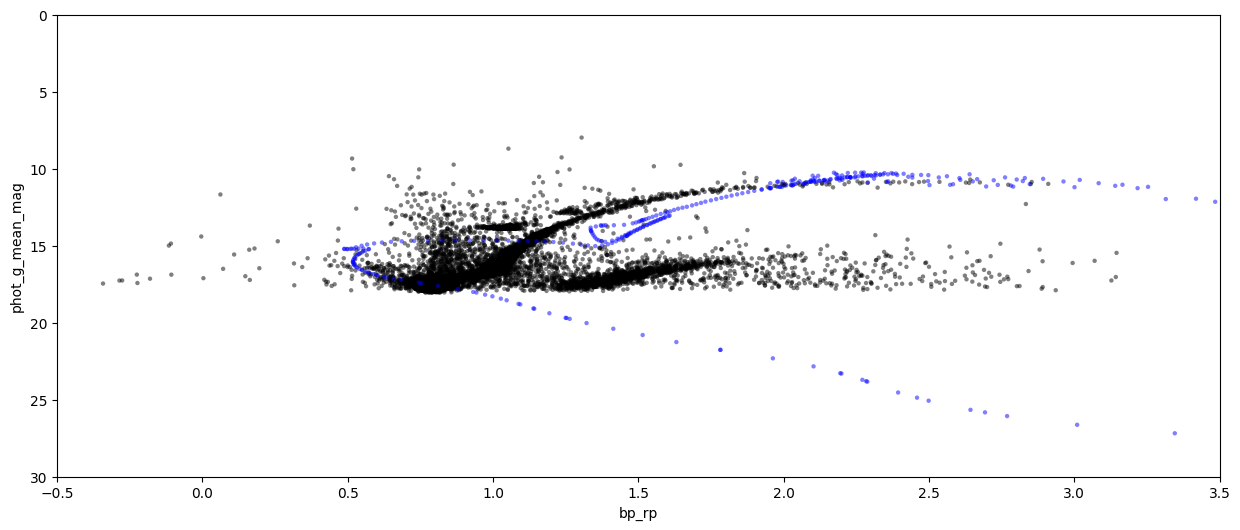

In [95]:
CATALOGO = dfr1_c2

# Crear la figura y los ejes
fig, ax = plt.subplots(figsize=(15, 6))

Mm = 13.45 + 0.5
# Extinción aproximada en la banda G A_G = 0.5
E_BP_RP = 0.3  # Enrojecimiento aproximado

# Crear el scatter plot
plt.scatter(x=CATALOGO.bp_rp, y=CATALOGO.phot_g_mean_mag,s=10, c="k", edgecolor='none', alpha=0.5)
plt.scatter(x=df_isc["G_BPmag"] - df_isc["G_RPmag"] + E_BP_RP , y=df_isc["Gmag"] + Mm,s=10, c="b", edgecolor='none', alpha=0.5)


# Etiquetas de los ejes
ax.set_xlabel('bp_rp')
ax.set_ylabel('phot_g_mean_mag')

# Ajustar límites de los ejes si es necesario
ax.set_xlim(-0.5, 3.5)
ax.set_ylim(0, 30)
plt.gca().invert_yaxis()
# Mostrar la gráfica
plt.show()

In [119]:
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import DBSCAN

COLS = ["pmra", "pmdec", "parallax"]
COLS_CLUS = COLS  #+ ['bp_rp', 'phot_g_mean_mag']

data = StandardScaler().fit_transform(CATALOGO[COLS_CLUS])
mask_nan = CATALOGO[COLS_CLUS].isna().any(axis=1).values
df = CATALOGO[~mask_nan]
data = data[~mask_nan]

Hacemos una búsqueda de parámetros que minimice la incertidumbre de los parámetros del cluster mayoritario.

In [120]:
#TODO: ¿Podríamos generar un proceso bayesiano que parta de un prior donde se le pase el paralaje y pm del cluster?

# Probar diferentes combinaciones de eps y min_samples
best_score = 1e6
best_params = None



for eps in np.linspace(0.1, 1.0, 10):  # Probar distintos eps
    for min_samples in range(3, 10):   # Probar distintos min_samples
        clustering = DBSCAN(eps=eps, min_samples=min_samples).fit(data)
        labels = clustering.labels_

        # Ignorar resultados con solo un cluster o solo ruido (-1)
        if len(set(labels[labels > -1])) > 1:
            unique_lab = np.unique(labels[labels > -1])
            j = np.argmax(np.bincount(labels[labels > -1]))
            mask = labels == unique_lab[j]
            gc = df[mask]
            score = gc[COLS].describe().loc["std"].sum()
            if score < best_score:
                best_score = score
                best_params = (eps, min_samples)

print(f"Mejores parámetros encontrados: eps={best_params[0]}, min_samples={best_params[1]} con coeficiente de silueta {best_score}")

Mejores parámetros encontrados: eps=0.1, min_samples=9 con coeficiente de silueta 0.842658771857304


In [121]:
db = DBSCAN(eps=best_params[0], min_samples=best_params[1]).fit(data)
labels = db.labels_

# Number of clusters in labels, ignoring noise if present.
n_clusters_ = len(set(labels)) - (1 if -1 in labels else 0)
n_noise_ = list(labels).count(-1)

print("Estimated number of clusters: %d" % n_clusters_)
print("Estimated number of noise points: %d" % n_noise_)

Estimated number of clusters: 2
Estimated number of noise points: 2006


In [122]:
print("Volumen total del catálogo: %d" % len(mask_0))

for label in np.unique(labels[labels >-1]):
    mask_i = labels == label
    print(f"Volumen total del cluster {label}: %d" % mask_i.sum())


Volumen total del catálogo: 15361
Volumen total del cluster 0: 13072
Volumen total del cluster 1: 1275


Volumen total del cluster 0: 13072
Volumen total del cluster 1: 1275


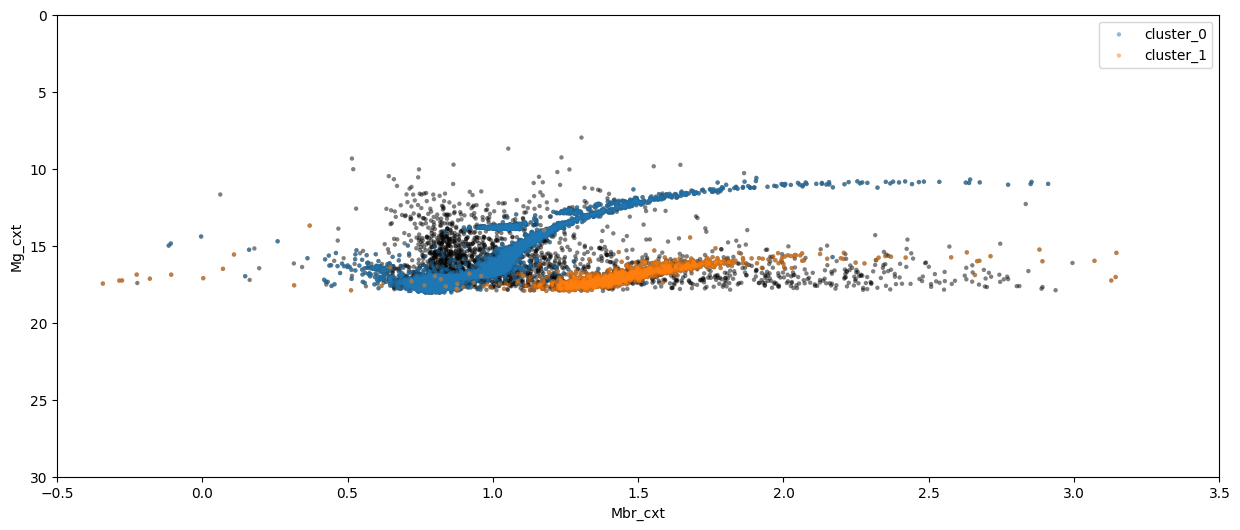

In [123]:

# Crear la figura y los ejes
fig, ax = plt.subplots(figsize=(15, 6))


# Crear el scatter plot
plt.scatter(x=df.bp_rp, y=df.phot_g_mean_mag,s=10, c="k", edgecolor='none', alpha=0.5)
for label in np.unique(labels[labels >-1]):
    mask_i = labels == label
    plt.scatter(x=df.bp_rp[mask_i], y=df.phot_g_mean_mag[mask_i],s=10, edgecolor='none', alpha=0.5, label=f"cluster_{label}")
    print(f"Volumen total del cluster {label}: %d" % mask_i.sum())


# Etiquetas de los ejes
ax.set_xlabel('Mbr_cxt')
ax.set_ylabel('Mg_cxt')

# Ajustar límites de los ejes si es necesario
ax.set_xlim(-0.5, 3.5)
ax.set_ylim(0, 30)
plt.gca().invert_yaxis()
# Mostrar la gráfica
plt.legend()
plt.show()

Seleccionamos el cluster 2 como candidato al cúmulo. Probamos a extraer sus pmra, pmdec y parallax.

In [127]:
unique_lab = np.unique(labels[labels > -1])
j = np.argmax(np.bincount(labels[labels > -1]))
mask = labels == unique_lab[j]
gc = df[mask]

print("Número de estrellas de CLuster seleccionado: %d" % gc.shape[0])
print("Número de HVS del CLuster seleccionado: %d" % gc[gc.pm_kms>200].shape[0])
display(gc[["pmra", "pmdec", "parallax"]].describe())

Número de estrellas de CLuster seleccionado: 13072
Número de HVS del CLuster seleccionado: 2539


,pmra,pmdec,parallax
count,13072.000000,13072.000000,13072.000000
mean,5.252491,-2.574601,0.195915
std,0.376776,0.387301,0.078582
min,3.545867,-4.084469,-0.191799
25%,5.006553,-2.841477,0.154092
50%,5.249993,-2.579771,0.195967
75%,5.495697,-2.306413,0.235998
max,7.153731,-1.050234,0.586312


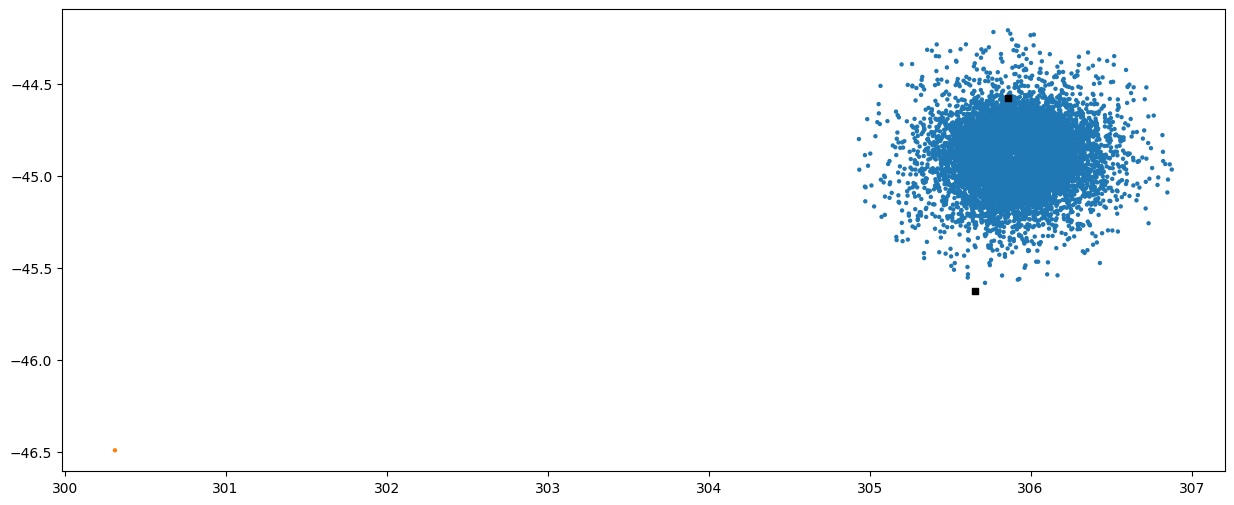

In [128]:
CATALOGO_6 = dfr6_c1

fig, ax = plt.subplots(figsize=(15, 6))
mask_p = (CATALOGO_6.parallax > gc.parallax.mean() - 2 * gc.parallax.std()) & (CATALOGO_6.parallax < gc.parallax.mean() + 2 * gc.parallax.std())
#mask_p = (CATALOGO_6.parallax > 0.09) & (CATALOGO_6.parallax < 0.45)
mask_hvs = ((CATALOGO_6.pmra.abs() > 50) | (CATALOGO_6.pmdec.abs() > 50)) & mask_p

plt.scatter(gc.l.values, gc.b.values, s=10, edgecolor='none', label="test")
plt.scatter(CATALOGO_6.l.values[mask_hvs], CATALOGO_6.b.values[mask_hvs], s=10, edgecolor='none', label="test")
plt.scatter(df_x.lii.values, df_x.bii.values, marker="s", s=20, color="k")

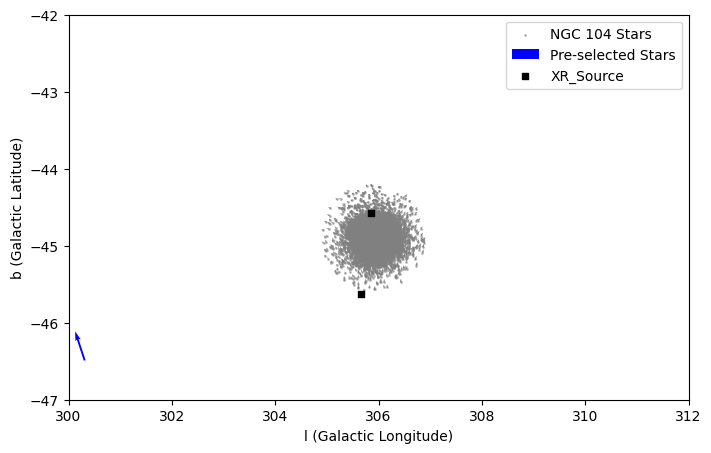

In [131]:
fig, ax = plt.subplots(figsize=(8, 5))

selected = CATALOGO_6[mask_hvs]
factor = 200

# Graficar las posiciones de las estrellas del cúmulo
ax.scatter(gc.l, gc.b, s=1, color="grey", alpha=0.5, label="NGC 104 Stars")

# Graficar vectores de movimiento propio
ax.quiver(gc.l, gc.b, gc.pm_l / factor, gc.pm_b / factor, color="grey", scale=5, width=0.003)

# Marcar las estrellas seleccionadas (ejemplo: aquellas con ciertas condiciones)

ax.quiver(selected["l"], selected["b"], selected["pm_l"] / factor, selected["pm_b"] / factor,
          color="blue", scale=5, width=0.003, label="Pre-selected Stars")

ax.scatter(df_x.lii.values, df_x.bii.values, marker="s", s=20, color="k", label="XR_Source")

# Etiquetas y detalles
ax.set_xlabel("l (Galactic Longitude)")
ax.set_ylabel("b (Galactic Latitude)")
ax.set_xlim(300, 312)
ax.set_ylim(-47, -42)
ax.legend()
plt.show()

## Referencias
- Kızıltan, B., Baumgardt, H., & Loeb, A. (2017). An intermediate-mass black hole in the centre of the globular cluster 47 Tucanae. Nature, 542(7640), 203-205.